# NLP project: Extracting skills from job descriptions.
# EDA

In [2]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt 
from collections import Counter 

from concurrent.futures import ThreadPoolExecutor 
from datasketch import MinHash, MinHashLSH 

import seaborn as sns
from nltk import ngrams
import random
from collections import defaultdict


In [8]:
df_prod = pd.read_excel('df_prod_29.04_2.xlsx', index_col=0)

In [4]:
print(df_prod.shape)
df_prod.head(2)

(147337, 9)


,id,name,alternate_url,salary.from,salary_new,description,branded_description,key_skills,professional_roles_new
26336,104519754,Руководитель отдела продаж,https://hh.ru/vacancy/104519754,100000,100000.00,"Привет, меня зовут Татьяна-я HR BP в офисе ""Во...",NaN,"Управление продажами, Управление командой, Раз...",Руководитель отдела продаж
26337,109734960,Руководитель отдела продаж автомобилей CHERY,https://hh.ru/vacancy/109734960,150000,172413.79,Мы формируем сильную команду отдела продаж и с...,c 1998 года\nVERRA — одна из ведущих автомобил...,"Управление продажами, Развитие продаж, Ответст...",Руководитель отдела продаж


In [9]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147337 entries, 26336 to 703318
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      147337 non-null  int64  
 1   name                    147337 non-null  object 
 2   alternate_url           147337 non-null  object 
 3   salary.from             147337 non-null  int64  
 4   salary_new              147337 non-null  float64
 5   description             147336 non-null  object 
 6   branded_description     75565 non-null   object 
 7   key_skills              63786 non-null   object 
 8   professional_roles_new  147337 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 11.2+ MB


In [10]:
df_prod[df_prod['description'].isnull()]['branded_description']

484899    NaN
Name: branded_description, dtype: object

In [11]:
df_prod = df_prod[~df_prod['description'].isnull()]
df_prod.shape

(147336, 9)

# 1. Предварительная подготовка корпуса данных

## 1.1 Анализ описания вакансии

In [727]:
# Набор всех символов ASCII, которые считаются печатными
PRINTABLE_CHARS = ''.join(chr(i) for i in range(32, 127)) + ''.join(chr(i) for i in range(128, 10000))

# Извлекаем все уникальные символы из поля description
all_chars = set()
for desc in df_prod['description']:
    all_chars.update(desc)

# Оставляем только печатные символы
printable_chars = sorted(char for char in all_chars if char in PRINTABLE_CHARS)

print("Список всех печатных символов в датасете:")
print(printable_chars)

Список всех печатных символов в датасете:
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '§', '©', '«', '\xad', '®', '°', '±', '²', '³', '·', '»', '¼', '½', '¾', 'À', 'Á', 'Ä', 'É', 'Ë', 'Ò', 'Ô', 'Ö', '×', 'Ø', 'Ü', 'à', 'á', 'â', 'ã', 'ä', 'è', 'é', 'ë', 'ó', 'ô', 'ö', '÷', 'ø', 'ú', 'ü', 'ý', 'ē', 'Ě', 'ğ', 'İ', 'ı', 'ĸ', 'Ō', 'Ş', 'Š', 'ˈ', '˖', '˘', '́', '̆', '̈', '̲', '̴', '̶', ';', 'Κ', 'Σ', 'α', 'Ё', 'І', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а'

Видим, что в тексте содержится много 'мусорных' символов.
Выполним предварительную обработку текста с описанием вакансий для поля description

In [12]:
def preprocess_text(text):
    # Разделяем слипшиеся слова (пример: "опытработы" -> "опыт работы")
    text = re.sub(r'([а-яё])([А-ЯЁ])', r'\1 \2', text)  # Разделяем CamelCase
    text = re.sub(r'([а-яёa-zА-ЯЁA-Z])([()])', r'\1 \2', text)  # отделим букву перед скобкой
    text = re.sub(r'([()])([а-яёa-zА-ЯЁA-Z])', r'\1 \2', text)  # отделим скобку перед буквой

    text = re.sub(r'<[^>]+>', '', text)             # Удаляем HTML-теги
    text = re.sub(r'\s+', ' ', text)                # Замена множественных пробелов на одиночный
    text = re.sub(r'\n|\t|•|\*', ' ', text)         # Удаляем переносы строк (\n), табы (\t) и символ • и *
    text = re.sub('ё', 'е', text)                   # Заеняем ё на е
    text = re.sub(r'[^\w\s.%&,/\-{}$$:;\']+', '', text) # финальная очистка текста (т.к выше выявили много непечатных символов)
     
    text = text.lower().strip() # Приводим текст к нижнему регистру
    
    return text

In [13]:
df_prod.loc[:,'description_clean'] = df_prod['description'].apply(preprocess_text)

In [14]:
df_prod[['description','description_clean']].head()

,description,description_clean
26336,"Привет, меня зовут Татьяна-я HR BP в офисе ""Во...","привет, меня зовут татьяна-я hr bp в офисе вой..."
26337,Мы формируем сильную команду отдела продаж и с...,мы формируем сильную команду отдела продаж и с...
26338,"Приветствую, меня зовут Алексей Якушев, основа...","приветствую, меня зовут алексей якушев, основа..."
26339,Если вы можете добиваться высоких продаж сами ...,если вы можете добиваться высоких продаж сами ...
26340,Чем предстоит заниматься: Организовать эффект...,чем предстоит заниматься: организовать эффекти...


Наша задача - выделить навыки из описания вакансий, а как правило,в описании вакансий требуемые навыки идут после краткого описания самой вакансии. Сократим текст для дальнейшей обработки, отделим часть, в которой содержатся требования к навыкам в отдельный столбец job_requirements.

In [15]:
# Список ключевых фраз для начала блока требований
keywords = [
'мы ждем от кандидата',
'мы ожидаем',
'необходимо обладать',
'требования',
'наши пожелания кандидатам',
'что желательно иметь кандидату',
'требования к кандидату',
'вам необходимо',
'мы подходим друг другу, если',
'наш идеальный кандидат',
'вы подходите, если',
'от вас мы ждем',
'нам может быть по пути, если ты',
'вы нам подходите, если у вас',
'пожелания к skill`ам',
'наши ожидания',
'мы ждем от вас',
'вашим преимуществом будет',
'вы нам подходите, если вы',
'наш идеальный руководитель',
'мы ждём от вас',
'необходимый опыт',
'что нужно от вас',
'от вас ожидаем',
'пожелания к кандидату',
'на что мы будем обращать внимание',
'ключевые требования',
'обязательные навыки',
'необходимые компетенции',
'профиль идеального кандидата',
'что нужно уметь',
'критерии отбора',
'что мы ценим в кандидатах',
'желательные компетенции',
'требуемый опыт',
'что вы должны знать',
'будущим сотрудникам необходимо',
'что сделает вас идеальным кандидатом',
'кого мы ищем',
'для успешной работы необходимо',
'какие hard skills нужны',
'какие hard skills важны',
'какие soft skills нужны',
'какие soft skills важны',
'что включено в job profile',
'что входит в job profile',
'что входит в job description',
'что включено в job description',
'мы мечтаем о кандидате, который',
'ваш скилл-сет должен включать',
'какие таланты мы ищем',
'что сделает вас звездой в этой роли',
'ваш опыт должен покрывать',
'ожидаем от кандидата',
'вы нам подходите если',
'ты идеальный кандидат, если',
'для нас важно',
' мы хотим видеть',
'от вас ждем',
'ожидаем от вас',
'вы нам подходите, если',
'от кандидатов мы ждем',
'кого мы ждем',
'наши пожелания',
'если у вас есть',
'ждем от кандидатов',
'требуемые навыки',
'ожидаем:',
'мы хотим увидеть у вас',
'будем ждать от тебя'     
'пожелания к кандидатам',
'ожидания от кандидата',
'вас в команде, если вы',
' требования',
'ждем от кандидата',
'подходим друг другу, если',
'ждём от кандидата',
'хотим видеть в кандидате',
'желательно иметь кандидату',
'мы ожидаем от кандидата',
'ты наш кандидат, если',
'мы ждём, что вы',
'хотим от кандидата',
 'ты точно нам подходишь, если',
'мы ищем специалиста, который',
'мы ждем, что ты',
'мы ждем кандидатов',
'нам подойдет кандидат',
'мы видим нашего кандидата',
'нам нужен кандидат, который',
'. нам важно',
'что мы ждем от тебя',
'мы ждем, что вы',
'мы ждем от нашего кандидата',
'наш будущий коллега',
'что ожидаем от тебя',
'кого мы ждём',
'. от вас',
'ждем от тебя',
'готовы работать с вами, если вы',
'кандидатуру, если у тебя ест',
' ждем человека, который',
'видеть для нас в кандидате',
'каким мы видим кандидата',
'мы ждем от тебя',
'нам с вами по пути, если вы',
'. важно',
' ждем кандидата, который',
'что нужно знать и уметь',
'мы ждем от будущего коллеги',
'кого мы видим на этой позиции',
'чем ты должен обладать',
'человек, которого мы ищем',
'портрет кандидата',
'вы точно наш кандидат, если вы',
'тебя в нашей команде, если ты',
'нашей команде, если у тебя есть',
'необходимые харды',
'ты точно наш кандидат, если ты',
'вас в нашей команде, если вы',
'нашей команде, если у вас есть',
'сотрудниковот вас',
'сотрудников от вас',
'какие кандидаты нам подходят',
'работа точно для вас, если вы',
'подойдет эта работа, если ты',
'детям по праздникам от вас',
'мы ищем',
'у вас получится, если есть',
'от тебя ждём',
'у тебя все получится, если ты',
'будем рады вам, если вы',
'для нас важны',
'каким мы видим сотрудника',
'будем рады тебе, если ты',
'и многое другое если вы',
'для детей сотрудниковот вас',
'для детей сотрудников  от вас',
'детям по праздникамот вас',
'подходит наша вакансия, если',
'мы ждем тебя, если ты',
'нам по пути если ты',
'сотрудников﻿от вас',
'сотрудников ﻿ от вас',
'в мире техники. если ты',
'тебе, если у тебя есть',
'. от тебя мы ждем',
'. что важно',
'тебя все получится, если',
'работать с нами, если ты',
'тебя в команде, если у тебя',
'нужно для успешной работы',
'пожелания к кандидатам'
]

def extract_job_requirements(description):
    for keyword in keywords:
        index = description.find(keyword)
        if index != -1:
            return description[index:]  # оставляю только часть после ключевого слова
    return None

df_prod.loc[:,'job_requirements'] = df_prod['description_clean'].apply(extract_job_requirements)

In [16]:
df_prod[['description','description_clean','job_requirements']].head()

,description,description_clean,job_requirements
26336,"Привет, меня зовут Татьяна-я HR BP в офисе ""Во...","привет, меня зовут татьяна-я hr bp в офисе вой...",мы ждем от кандидата: опыт в продажах b2b опы...
26337,Мы формируем сильную команду отдела продаж и с...,мы формируем сильную команду отдела продаж и с...,мы ожидаем: опыт в аналогичной должности от 1-...
26338,"Приветствую, меня зовут Алексей Якушев, основа...","приветствую, меня зовут алексей якушев, основа...",необходимо обладать: опытом работы в сфере про...
26339,Если вы можете добиваться высоких продаж сами ...,если вы можете добиваться высоких продаж сами ...,"требования: наличие результатов, достижений н..."
26340,Чем предстоит заниматься: Организовать эффект...,чем предстоит заниматься: организовать эффекти...,наши пожелания кандидатам: высшее образование ...


In [17]:
df_prod[['id','description','description_clean','job_requirements']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147336 entries, 26336 to 703318
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 147336 non-null  int64 
 1   description        147336 non-null  object
 2   description_clean  147336 non-null  object
 3   job_requirements   121855 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.6+ MB


Итог: удалось выделить 121 855 строк с требованиями к каздидатам

## Выделим в отдельный датасет описание вакансий

Создадим датасет df_description с уникальными описаниями вакансий В основном датасете df_prod проставим идентификаторы уникальных описаний вакансий job_requirements_id

In [751]:
unique_descriptions = df_prod['job_requirements'].drop_duplicates().reset_index(drop=True)
unique_descriptions.index += 1  # Индексация с 1, чтобы ID начинался с 1
unique_descriptions.name = 'job_requirements'
unique_descriptions = unique_descriptions.reset_index().rename(columns={'index': 'job_requirements_id'})

map_desc_to_id = dict(unique_descriptions.set_index('job_requirements')['job_requirements_id'])

df_prod.loc[:,'job_requirements_id'] = df_prod['job_requirements'].map(map_desc_to_id)

df_description = unique_descriptions.copy()

In [753]:
df_prod.head(2)

,id,name,alternate_url,salary.from,salary_new,description,branded_description,key_skills,professional_roles_new,description_clean,job_requirements,job_requirements_id
26336,104519754,Руководитель отдела продаж,https://hh.ru/vacancy/104519754,100000,100000.00,"Привет, меня зовут Татьяна-я HR BP в офисе ""Во...",NaN,"Управление продажами, Управление командой, Раз...",Руководитель отдела продаж,"привет, меня зовут татьяна-я hr bp в офисе вой...",мы ждем от кандидата: опыт в продажах b2b опы...,1
26337,109734960,Руководитель отдела продаж автомобилей CHERY,https://hh.ru/vacancy/109734960,150000,172413.79,Мы формируем сильную команду отдела продаж и с...,c 1998 года\nVERRA — одна из ведущих автомобил...,"Управление продажами, Развитие продаж, Ответст...",Руководитель отдела продаж,мы формируем сильную команду отдела продаж и с...,мы ожидаем: опыт в аналогичной должности от 1-...,2


In [755]:
df_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57715 entries, 0 to 57714
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_requirements_id  57715 non-null  int64 
 1   job_requirements     57714 non-null  object
dtypes: int64(1), object(1)
memory usage: 901.9+ KB


In [757]:
df_description = df_description[df_description['job_requirements'].notnull()]

In [759]:
df_description.head(3)

,job_requirements_id,job_requirements
0,1,мы ждем от кандидата: опыт в продажах b2b опы...
1,2,мы ожидаем: опыт в аналогичной должности от 1-...
2,3,необходимо обладать: опытом работы в сфере про...


In [761]:
df_description['job_requirements'] = (
    df_description['job_requirements']
    .astype(str)  # Гарантирует, что всё — строки
    .str.strip()   # Удаляет пробелы по краям
)

In [763]:
# Проверка
print(df_description['job_requirements'].apply(type).unique())  # Выведет [<class 'str'>]

[<class 'str'>]


Найдем и удалим полные дубликаты

In [782]:
duplicates = df_description[df_description.duplicated('job_requirements', keep=False)]
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 73 полных дубликатов


In [784]:
df_description = df_description.drop_duplicates(subset='job_requirements')

Дополнительно предобработаю текст - заметила, что в некоторых строках идет тире или минус после знаков препинания (пример job_requirements_id = 72181)

In [768]:
pattern = r'([:;,.-]\s*-)|(-)'
replacement = lambda x: x.group().strip('- ')
df_description['job_requirements'] = df_description['job_requirements'].str.replace(pattern, replacement, regex=True)

In [770]:
# Добавляем столбцы с длиной текста
df_description['char_len'] = df_description['job_requirements'].str.len()
df_description['word_len'] = df_description['job_requirements'].str.split().str.len()

In [786]:
print("Статистика длины текста:")
print(df_description[['char_len', 'word_len']].describe())

Статистика длины текста:
           char_len      word_len
count  57675.000000  57675.000000
mean     701.375050     92.315995
std      492.549849     66.832931
min       12.000000      1.000000
25%      357.000000     46.000000
50%      583.000000     76.000000
75%      903.000000    119.000000
max     6205.000000    792.000000


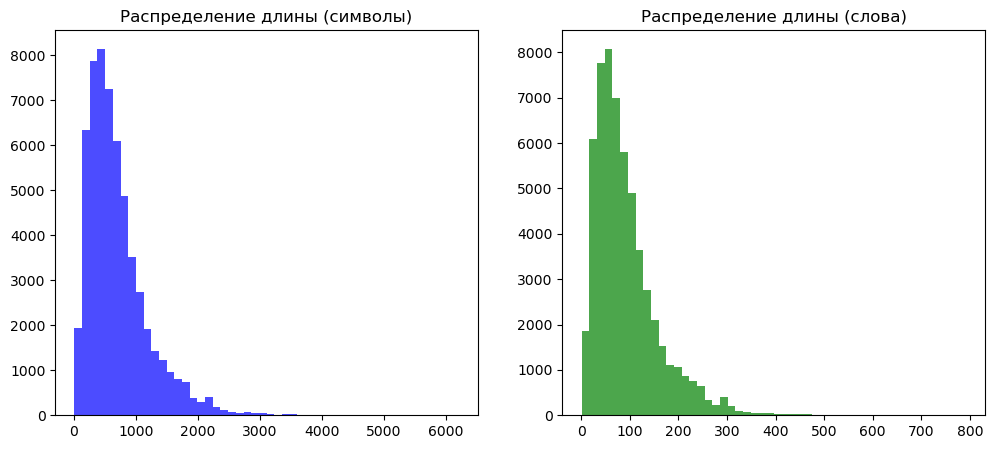

In [788]:
# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_description['char_len'], bins=50, color='blue', alpha=0.7)
plt.title('Распределение длины (символы)')

plt.subplot(1, 2, 2)
plt.hist(df_description['word_len'], bins=50, color='green', alpha=0.7)
plt.title('Распределение длины (слова)')
plt.show()

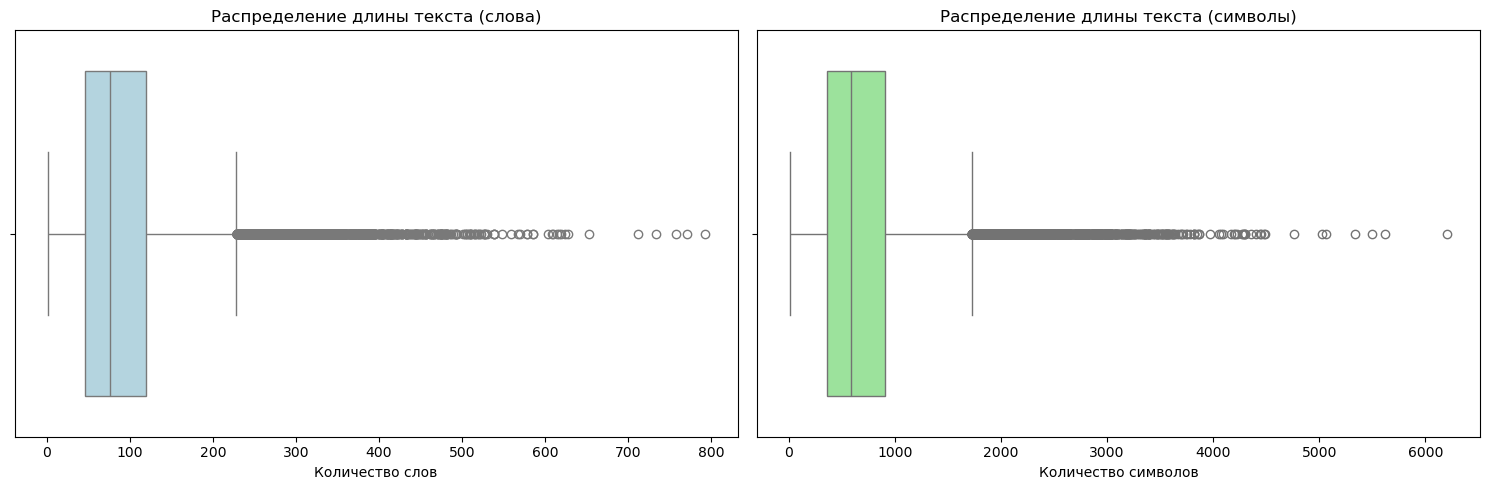

In [790]:
# Визуализация распределений
plt.figure(figsize=(15, 5))

# Боксплот для длины в словах
plt.subplot(1, 2, 1)
sns.boxplot(x=df_description['word_len'], color='lightblue')
plt.title('Распределение длины текста (слова)')
plt.xlabel('Количество слов')

# Боксплот для длины в символах
plt.subplot(1, 2, 2)
sns.boxplot(x=df_description['char_len'], color='lightgreen')
plt.title('Распределение длины текста (символы)')
plt.xlabel('Количество символов')

plt.tight_layout()
plt.show()

In [792]:
# Для длины в словах
Q1 = df_description['word_len'].quantile(0.25)
Q3 = df_description['word_len'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Границы выбросов (слова): [{lower_bound}, {upper_bound}]")

Границы выбросов (слова): [-63.5, 228.5]


In [794]:
# Анализ перцентилей длины
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
print("Перцентили длины (слова):")
print(df_description['word_len'].quantile(percentiles))

Перцентили длины (слова):
0.01     11.00
0.05     20.00
0.25     46.00
0.50     76.00
0.75    119.00
0.90    180.00
0.95    227.00
0.99    312.26
Name: word_len, dtype: float64


In [800]:
min_words = 11  # Нижний 1%
max_words =227  # Верхний 95%

In [802]:
df_description[(df_description['word_len'] < min_words) | (df_description['word_len'] > max_words)]

,job_requirements_id,job_requirements,char_len,word_len
14,15,требования: опыт работы в управлении отделом п...,1879,252
18,19,"нам может быть по пути, если ты: имеешь высшее...",2808,399
41,42,требованиям современной стоматологии. а также ...,2321,297
43,44,требования: опыт работы в аналогичной должност...,1879,239
54,55,мы ищем активного и целеустремленного сотрудни...,1691,243
...,...,...,...,...
57650,57651,для нас важны: любовь к спорту и активному обр...,2233,300
57684,57685,требования дружелюбность и желание помогать кл...,1788,237
57691,57692,требования к кандидату: желателен опыт работы ...,1803,248
57696,57697,мы ищем менеджеров для работы с покупателями в...,1755,229


In [804]:
df_description = df_description[(df_description['word_len'] >= min_words) & (df_description['word_len'] <= max_words)]

In [866]:
df_description.shape

(54266, 4)

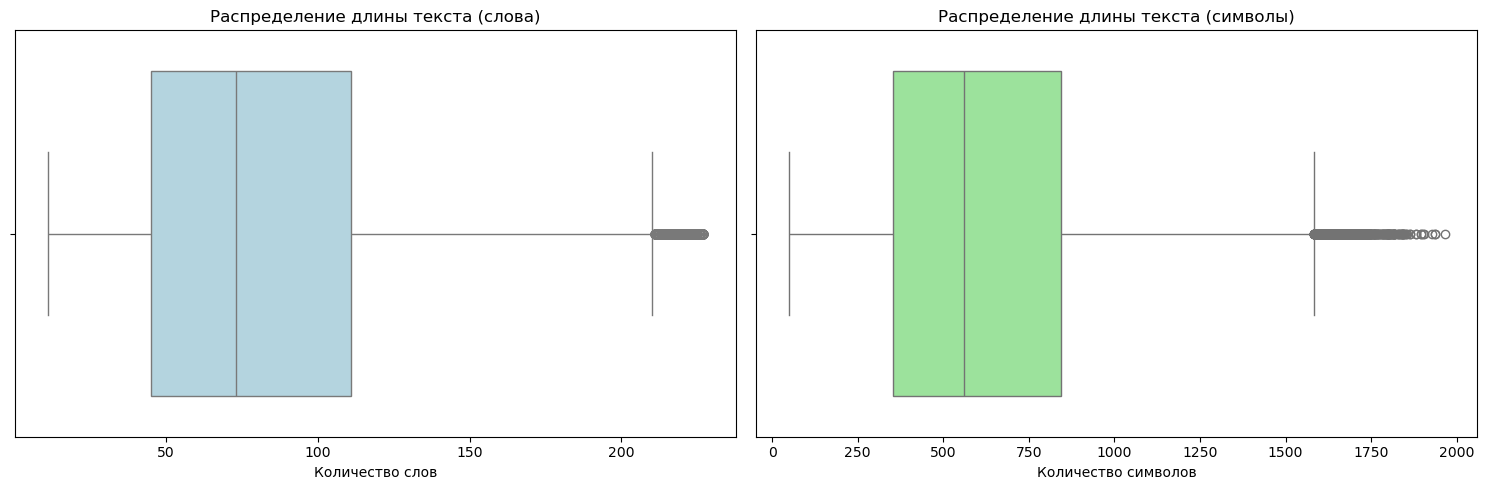

In [838]:
# Визуализация распределений
plt.figure(figsize=(15, 5))

# Боксплот для длины в словах
plt.subplot(1, 2, 1)
sns.boxplot(x=df_description['word_len'], color='lightblue')
plt.title('Распределение длины текста (слова)')
plt.xlabel('Количество слов')

# Боксплот для длины в символах
plt.subplot(1, 2, 2)
sns.boxplot(x=df_description['char_len'], color='lightgreen')
plt.title('Распределение длины текста (символы)')
plt.xlabel('Количество символов')

plt.tight_layout()
plt.show()

In [806]:
# Функция для создания MinHash с прогресс-баром
def get_minhash_with_progress(text, num_perm=128):
    mh = MinHash(num_perm=num_perm)
    for word in tqdm(text.split(), desc="Создание MinHash", leave=False):
        mh.update(word.encode('utf-8'))
    return mh

In [808]:
Создание индекса с прогресс-баром
lsh = MinHashLSH(threshold=0.9, num_perm=128)

In [810]:
print("Создание индекса LSH...")
for idx, row in tqdm(df_description.iterrows(), total=len(df_description), desc="Обработка строк"):
    lsh.insert(idx, get_minhash(row['job_requirements']))

Создание индекса LSH...


Обработка строк: 100%|██████████| 54266/54266 [02:37<00:00, 344.74it/s]


In [812]:
similar_pairs = []
print("\nПоиск похожих пар...")


Поиск похожих пар...


In [814]:
for idx, row in tqdm(df_description.iterrows(), total=len(df_description), desc="Сравнение документов"):
    matches = lsh.query(get_minhash(row['job_requirements']))
    for match in matches:
        if match != idx:
            similar_pairs.append((idx, match))

Сравнение документов: 100%|██████████| 54266/54266 [02:34<00:00, 351.22it/s]


In [816]:
# Удаление дубликатов пар (A-B и B-A)
unique_pairs = set(tuple(sorted(pair)) for pair in similar_pairs)
print(f"\nНайдено {len(unique_pairs)} уникальных похожих пар")


Найдено 14740 уникальных похожих пар


In [818]:
import random

In [822]:
# Преобразуем множество в список для работы с индексами
unique_pairs_list = list(unique_pairs)

In [824]:
# Просмотр случайных 5 пар с правильной нумерацией
for i, pair in enumerate(random.sample(unique_pairs_list, min(3, len(unique_pairs_list)))):
    idx1, idx2 = pair
    print(f"\nПара #{i}:")
    print(f"Текст 1 (ID {idx1}):\n{df_description.loc[idx1, 'job_requirements'][:200]}...")
    print(f"\nТекст 2 (ID {idx2}):\n{df_description.loc[idx2, 'job_requirements'][:200]}...")
    print("\n" + "-" * 80)


Пара #0:
Текст 1 (ID 47185):
от тебя ждём: опыт работы в продажах желателен, но не является обязательным; грамотную речь и желание достойно зарабатывать; ты открыт к новому и не боишься изменений; ты любишь людей и считаешь важны...

Текст 2 (ID 53334):
от тебя ждём: опыт работы в продажах желателен, но не является обязательным; грамотную речь и желание достойно зарабатывать; ты открыт к новому и не боишься изменений; ты любишь людей и считаешь важны...

--------------------------------------------------------------------------------

Пара #1:
Текст 1 (ID 14077):
требования: знание 1с. microsoft office. условия: заработная плата на испытательный срок 80 000 рублей. заработная плата после испытательного срока от 100 000 рублей. верхней границы нет. корпоративны...

Текст 2 (ID 24936):
требования: знание 1с. microsoft office. условия: заработная плата на испытательный срок 70 000 рублей. заработная плата после испытательного срока от 70 000 рублей. верхней границы нет. корпоративный...


In [828]:
# Создаем список для хранения данных
similar_texts_data = []

# Обрабатываем пары с прогресс-баром
for pair_num, (idx1, idx2) in tqdm(enumerate(unique_pairs_list), 
                                  total=len(unique_pairs_list),
                                  desc="Формирование данных"):
    
    # Получаем тексты
    text1 = df_description.loc[idx1, 'job_requirements']
    text2 = df_description.loc[idx2, 'job_requirements']
    
    # Добавляем в список оба текста пары
    similar_texts_data.append({
        'Номер пары': f'Пара {pair_num}',
        'ID текста': idx1,
        'Текст': text1
    })
    
    similar_texts_data.append({
        'Номер пары': f'Пара {pair_num}',
        'ID текста': idx2,
        'Текст': text2
    })


Формирование данных: 100%|██████████| 14740/14740 [00:00<00:00, 39813.48it/s]


In [832]:
similar_texts_df = pd.DataFrame(similar_texts_data)
similar_texts_df.head()
similar_texts_df['ID текста'].nunique()

7485

In [834]:
similar_texts_df.to_excel('similar_texts_df_2505.xlsx')

In [842]:
similar_texts_df.head()

,Номер пары,ID текста,Текст
0,Пара 0,18591,требования к кандидатам: образование: не ниже ...
1,Пара 0,22643,требования к кандидатам: образование: не ниже ...
2,Пара 1,10853,наши ожидания: высокоразвитые коммуникативные ...
3,Пара 1,24433,наши ожидания: высокоразвитые коммуникативные ...
4,Пара 2,42104,какие кандидаты нам подходят: готовые общаться...


In [872]:
# Находим все связанные группы дубликатов (компоненты связности графа)
visited = set()
groups = []

for node in duplicate_groups:
    if node not in visited:
        # Начинаем новый кластер
        stack = [node]
        cluster = []
        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                cluster.append(current)
                # Добавляем всех соседей
                stack.extend(duplicate_groups[current])
        groups.append(cluster)

In [874]:
# Выбираем по одному представителю из каждой группы
representatives = set()
for group in groups:
    # Выбираем самый частый текст как представитель
    texts = [df_description.loc[idx, 'job_requirements'] for idx in group]
    most_common = Counter(texts).most_common(1)[0][0]
    representative = group[texts.index(most_common)]
    representatives.add(representative)

In [876]:
# Получаем все ID, которые НЕ являются дубликатами
non_duplicate_ids = set(df_description.index) - visited

In [878]:
# Объединяем представителей и уникальные тексты
final_ids = non_duplicate_ids.union(representatives)

In [880]:
unique_df = df_description.loc[list(final_ids)].copy()

In [882]:
print(f"Исходное количество строк: {len(df_description)}")
print(f"Уникальных текстов осталось: {len(unique_df)}")
print(f"Удалено дубликатов: {len(df_description) - len(unique_df)}")
print(f"Количество групп дубликатов: {len(groups)}")

Исходное количество строк: 54266
Уникальных текстов осталось: 49401
Удалено дубликатов: 4865
Количество групп дубликатов: 2620


In [894]:
unique_df.shape

(49401, 4)

In [896]:
unique_df.head(3)

,job_requirements_id,job_requirements,char_len,word_len
0,1,мы ждем от кандидата: опыт в продажах b2b опы...,198,30
1,2,мы ожидаем: опыт в аналогичной должности от 1г...,723,86
2,3,необходимо обладать: опытом работы в сфере про...,1723,224


In [898]:
unique_df[['job_requirements_id', 'job_requirements']].to_excel('df_description_2605.xlsx')

In [18]:
df_prod.shape

(147336, 11)

## Анализ навыков из столбца key_skills

In [20]:
df_prod.loc[:,'key_skills_new'] = df_prod['key_skills']

Сделаем предобработку key_skills

In [21]:
df_prod['key_skills_new'] = df_prod['key_skills_new'].fillna('')  # Замена NaN на пустые строки
df_prod['key_skills_new'] = df_prod['key_skills_new'].str.lower()  # Приведение к нижнему регистру
df_prod['key_skills_new'] = df_prod['key_skills_new'].str.replace(r'[^\w\s,]', '', regex=True)  # Удаление спецсимволов
df_prod['key_skills_new'] = df_prod['key_skills_new'].str.replace(r'ё', 'е', regex=True)  # Удаление спецсимволов
df_prod['key_skills_list'] = df_prod['key_skills_new'].str.split(', ')  # Разделение навыков в список

In [22]:
filled_skills = (df_prod['key_skills_new'] != '').mean() * 100
print(f"Заполнено key_skills: {filled_skills:.1f}% вакансий")

Заполнено key_skills: 43.3% вакансий


count    147336.000000
mean          3.059307
std           4.695245
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max          55.000000
Name: key_skills_list, dtype: float64


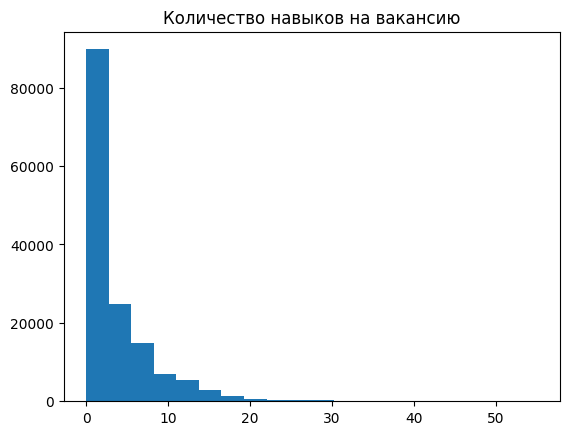

In [23]:
# Распределение количества навыков на вакансию
skills_per_vacancy = df_prod['key_skills_list'].apply(lambda x: len(x) if x != [''] else 0)
print(skills_per_vacancy.describe())
plt.hist(skills_per_vacancy, bins=20)
plt.title('Количество навыков на вакансию')
plt.show()

Посмотрим Топ-20 самых частых навыков

Топ-20 навыков:
активные продажи: 25761
навыки продаж: 17993
телефонные переговоры: 14662
работа в команде: 12483
поиск и привлечение клиентов: 11647
деловое общение: 11445
грамотная речь: 11380
прямые продажи: 10598
b2b продажи: 8741
заключение договоров: 8325
развитие продаж: 7881
деловая переписка: 6886
ведение переговоров: 6774
розничная торговля: 6772
пользователь пк: 6620
навыки переговоров: 5871
обслуживание покупателей: 5768
клиентоориентированность: 5425
холодные продажи: 5258
деловая коммуникация: 5171


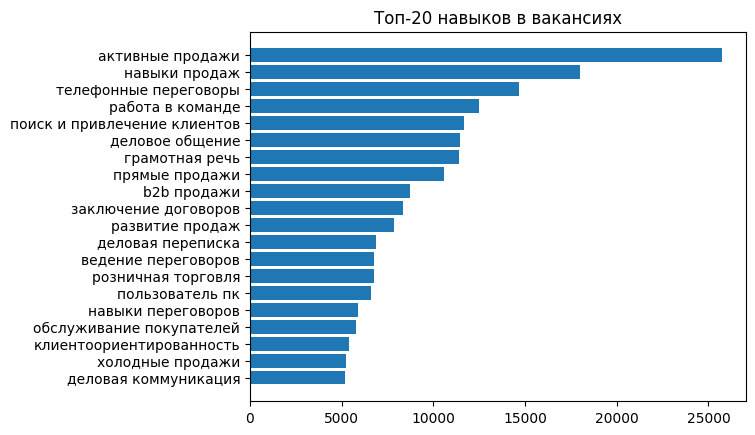

In [25]:
all_skills = [skill for sublist in df_prod['key_skills_list'] for skill in sublist if skill]
skill_counts = Counter(all_skills).most_common(20)

print("Топ-20 навыков:")
for skill, count in skill_counts:
    print(f"{skill}: {count}")

# Визуализация
skills, counts = zip(*skill_counts)
plt.barh(skills[::-1], counts[::-1])  # Горизонтальный барчарт
plt.title('Топ-20 навыков в вакансиях')
plt.show()

Посмотрим профессиональные роли в столбце professional_roles_new

In [26]:
print(df_prod['professional_roles_new'].unique())

['Руководитель отдела продаж' 'Торговый представитель'
 'Директор магазина, директор сети магазинов'
 'Менеджер по продажам, менеджер по работе с клиентами'
 'Администратор магазина, администратор торгового зала'
 'Продавец-консультант, продавец-кассир']


In [27]:
#Топ-5 навыков для каждой роли
# Группировка по professional_roles_new
role_skills = df_prod.explode('key_skills_list').groupby('professional_roles_new')['key_skills_list'].value_counts()

# Топ-5 навыков для каждой роли
role_skills.groupby('professional_roles_new').head(6)

professional_roles_new                                key_skills_list                    
Администратор магазина, администратор торгового зала                                         11712
                                                      розничная торговля                       674
                                                      обучение персонала                       638
                                                      работа в команде                         527
                                                      управление персоналом                    513
                                                      кассовые операции                        415
Директор магазина, директор сети магазинов                                                    7605
                                                      обучение персонала                       777
                                                      организаторские навыки                   683
                   

In [28]:
all_skills

['управление продажами',
 'управление командой',
 'развитие продаж',
 'аналитика продаж',
 'b2b продажи',
 'мотивация персонала',
 'управление отношениями с клиентами',
 'прямые продажи',
 'подбор персонала',
 'управление работой с ключевыми клиентами',
 'заключение договоров',
 'телефонные переговоры',
 'управление продажами',
 'развитие продаж',
 'ответственность',
 'исполнительность',
 'работоспособность',
 'стратегия продаж',
 'планирование продаж',
 'управление продажами',
 'планирование продаж',
 'активные продажи',
 'b2b продажи',
 'руководство коллективом',
 'управленческие навыки',
 'развитие продаж',
 'мотивация персонала',
 'аналитика продаж',
 'организаторские навыки',
 'обучение персонала',
 'обучение и развитие',
 'управление командой',
 'анализ продаж',
 'умение принимать решения',
 'обучение команды продаж',
 'формирование команды',
 'управление сотрудниками в регионах',
 'аналитическое мышление',
 'деловое общение',
 'деловая переписка',
 'лидерство',
 'crm',
 'битрикс

In [29]:
unique_skills = set(all_skills)
print(f"Всего уникальных навыков: {len(unique_skills)}")

Всего уникальных навыков: 7148


In [30]:
skill_counts_1000 = Counter(all_skills).most_common(1000)

In [31]:
skill_counts_1000

[('активные продажи', 25761),
 ('навыки продаж', 17993),
 ('телефонные переговоры', 14662),
 ('работа в команде', 12483),
 ('поиск и привлечение клиентов', 11647),
 ('деловое общение', 11445),
 ('грамотная речь', 11380),
 ('прямые продажи', 10598),
 ('b2b продажи', 8741),
 ('заключение договоров', 8325),
 ('развитие продаж', 7881),
 ('деловая переписка', 6886),
 ('ведение переговоров', 6774),
 ('розничная торговля', 6772),
 ('пользователь пк', 6620),
 ('навыки переговоров', 5871),
 ('обслуживание покупателей', 5768),
 ('клиентоориентированность', 5425),
 ('холодные продажи', 5258),
 ('деловая коммуникация', 5171),
 ('проведение презентаций', 4939),
 ('консультирование клиентов', 4893),
 ('выкладка товаров', 4593),
 ('обучение и развитие', 4566),
 ('управление продажами', 4512),
 ('ориентация на результат', 4339),
 ('планирование продаж', 4115),
 ('подготовка коммерческих предложений', 3971),
 ('навыки презентации', 3875),
 ('кассовые операции', 3757),
 ('работа с текущей базой клиентов

In [33]:
skill_counts_1000 = pd.DataFrame(skill_counts_1000, columns=['skills', 'count'])

In [34]:
skill_counts_1000.head(3)

,skills,count
0,активные продажи,25761
1,навыки продаж,17993
2,телефонные переговоры,14662


In [37]:
skill_counts_1000.to_excel('skill_counts_1000.xlsx')